In [1]:
import pandas as pd

## DATA OVERVIEW


In [2]:
data = pd.read_csv("usdinr.csv")
data.head()

,Date,Price,Open,High,Low
0,"Sep 14, 2018",71.880,71.700,71.995,71.535
1,"Sep 17, 2018",72.540,72.530,72.695,72.315
2,"Sep 18, 2018",72.710,72.560,72.990,72.360
3,"Sep 19, 2018",72.360,72.720,72.875,72.345
4,"Sep 20, 2018",72.015,72.345,72.345,72.015


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 5 columns):
Date     261 non-null object
Price    261 non-null float64
Open     261 non-null float64
High     261 non-null float64
Low      261 non-null float64
dtypes: float64(4), object(1)
memory usage: 10.3+ KB


## Data Preprocessing

In [4]:
import datetime 

# Converting date to correct format.

def handle_date(date):
    entity_list = date.split(' ')
    
    entity_list[1] = entity_list[1][0:2]
    date_string = entity_list[0] + ' ' + entity_list[1] + ' ' + entity_list[2]
    datetime_object = datetime.datetime.strptime(date_string, '%b %d %Y')
    return datetime_object


data['Date']=data['Date'].apply(lambda date : handle_date(date) )

In [5]:
data.head()

,Date,Price,Open,High,Low
0,2018-09-14,71.880,71.700,71.995,71.535
1,2018-09-17,72.540,72.530,72.695,72.315
2,2018-09-18,72.710,72.560,72.990,72.360
3,2018-09-19,72.360,72.720,72.875,72.345
4,2018-09-20,72.015,72.345,72.345,72.015


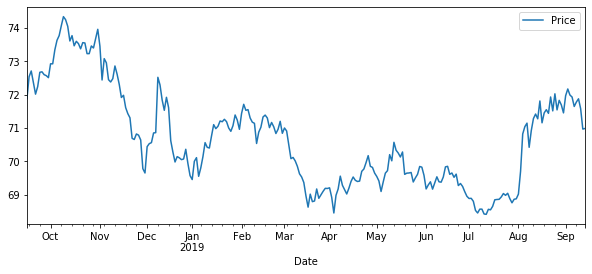

In [6]:
%matplotlib inline
data.plot(x='Date', y='Price', figsize=(10,4))


Applying normmalization to close price using min max normalization

In [7]:
data['Price'] =  ( data['Price'] - data['Price'].min() ) / (data['Price'].max() - data['Price'].min())

In [8]:
data.head()

,Date,Price,Open,High,Low
0,2018-09-14,0.585160,71.700,71.995,71.535
1,2018-09-17,0.696459,72.530,72.695,72.315
2,2018-09-18,0.725126,72.560,72.990,72.360
3,2018-09-19,0.666105,72.720,72.875,72.345
4,2018-09-20,0.607926,72.345,72.345,72.015


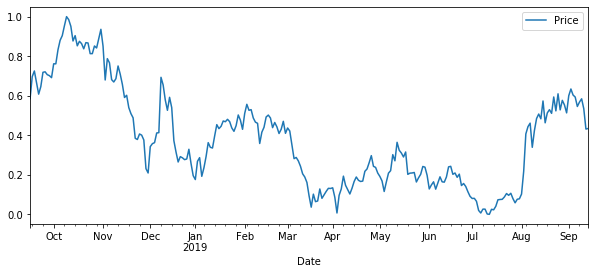

In [9]:
data.plot(x='Date', y='Price', figsize=(10,4))

In [10]:
import torch 
from torch import nn

class RNN(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers):
        
        super(RNN,self).__init__()
        
        self.rnn = nn.RNN(input_dim,hidden_dim,n_layers,batch_first=True)
        
        self.hidden_size = hidden_dim
        
        self.linear = nn.Linear(hidden_dim,output_dim)
        
        
        
    def forward(self,x,hidden):
        
        batch_size = x.size(0)
        r_out , hidden = self.rnn(x,hidden)
        
        r_out = r_out.view(-1,self.hidden_size)
        
        output = self.linear(r_out)
        
        return output,hidden
        

In [11]:
input_size = 1
output_size =1
hidden_size=32
n_layers=1

rnn = RNN(input_size,hidden_size,output_size,n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [13]:
prices = data['Price'].to_numpy()
prices = prices.reshape(-1,1)

In [14]:
prices[0:15]

array([[0.5851602 ],
       [0.69645868],
       [0.72512648],
       [0.66610455],
       [0.6079258 ],
       [0.64586847],
       [0.71838111],
       [0.72091062],
       [0.70657673],
       [0.70151771],
       [0.69139966],
       [0.7613828 ],
       [0.7613828 ],
       [0.83220911],
       [0.88026981]])

In [15]:
split_idx = int(0.7*len(prices))
split_idx

182

In [16]:
import numpy as np

seq_length = 15
X_train = []
y_train =[] 

for i in range(seq_length, split_idx):
    
    X_train.append(prices[(i-seq_length):i,0])
    y_train.append(prices[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train

    

array([[0.5851602 , 0.69645868, 0.72512648, ..., 0.7613828 , 0.83220911,
        0.88026981],
       [0.69645868, 0.72512648, 0.66610455, ..., 0.83220911, 0.88026981,
        0.90387858],
       [0.72512648, 0.66610455, 0.6079258 , ..., 0.88026981, 0.90387858,
        0.95362563],
       ...,
       [0.16863406, 0.11551433, 0.16357504, ..., 0.20219224, 0.20826307,
        0.20910624],
       [0.11551433, 0.16357504, 0.20826307, ..., 0.20826307, 0.20910624,
        0.21163575],
       [0.16357504, 0.20826307, 0.22091062, ..., 0.20910624, 0.21163575,
        0.16357504]])

In [17]:
sample = X_train[0].reshape((seq_length,1))
sample = torch.Tensor(sample).unsqueeze(0)
sample.shape

torch.Size([1, 15, 1])

In [18]:
sample = X_train[0].reshape((seq_length,1))
sample


array([[0.5851602 ],
       [0.69645868],
       [0.72512648],
       [0.66610455],
       [0.6079258 ],
       [0.64586847],
       [0.71838111],
       [0.72091062],
       [0.70657673],
       [0.70151771],
       [0.69139966],
       [0.7613828 ],
       [0.7613828 ],
       [0.83220911],
       [0.88026981]])

In [19]:
X =X_train[1]
X.resize((seq_length,1))
X.shape

(15, 1)

In [33]:
x_tensor= X [ : -1]
y_tensor = X[ 1: ]


print(x_tensor.shape)
print(y_tensor.shape)

x_tensor = torch.Tensor(x_tensor).unsqueeze(0)

print(x_tensor.shape)
y_tensor = torch.Tensor(y_tensor)
print(y_tensor.shape)

output , hidden = rnn(x_tensor,None)
print(output.shape)

loss = criterion(output,y_tensor)
loss



(14, 1)
(14, 1)
torch.Size([1, 14, 1])
torch.Size([14, 1])
torch.Size([14, 1])
(14,)


In [21]:
X_train.shape

(167, 15)

In [45]:
steps = [ i for i in range(1,15)]
steps

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [50]:
import matplotlib.pyplot as plt

steps = [ i for i in range(1,15)]
steps = np.array(steps)

def train(rnn, n_epochs):
    
    hidden = None
    
    
    for i in range(n_epochs):
        
        index = random.randint(0,len(X_train))
        
        
        X = X_train[index]
        
        X.resize((seq_length,1))
        
        x = X [ : -1]
        x_tensor= X [ : -1]
        y_tensor = X[ 1: ]
        
        x_tensor = torch.Tensor(x_tensor).unsqueeze(0)
        y_tensor = torch.Tensor(y_tensor)
        
        output,hidden = rnn(x_tensor,hidden)
        
        hidden = hidden.data
        
        loss = criterion(output,y_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        
        print('epoch {}, loss {}'.format(i,loss.item()))
        plt.plot(steps,x_tensor.data.numpy().flatten(),'r.')
        plt.plot(steps,y_tensor.data.numpy().flatten(),'b.')
    
        plt.show()

        
    return rnn
        

epoch 0, loss 0.16478028893470764


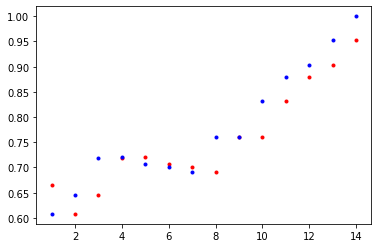

epoch 1, loss 0.003472180338576436


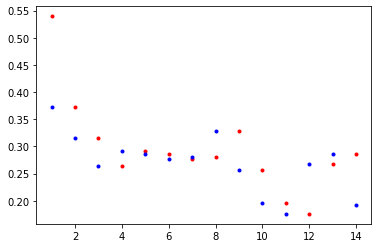

epoch 2, loss 0.008598254062235355


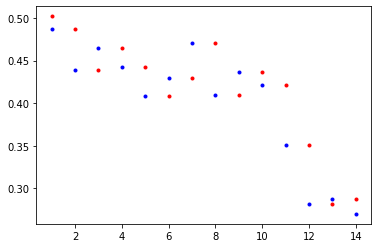

epoch 3, loss 0.006668806076049805


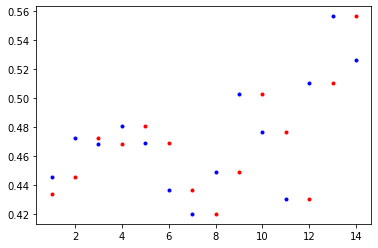

epoch 4, loss 0.03956996276974678


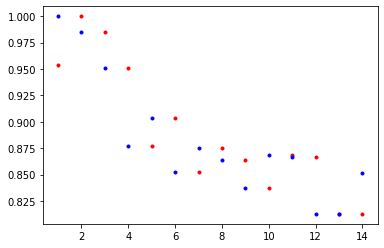

epoch 5, loss 0.049663882702589035


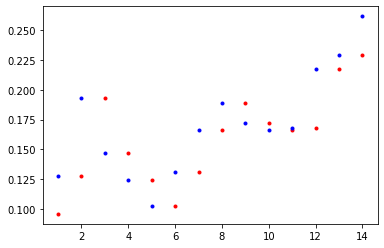

epoch 6, loss 0.028773926198482513


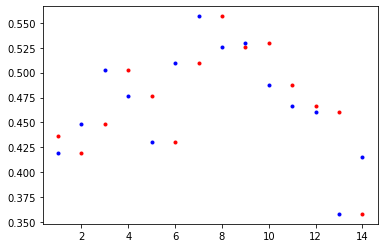

epoch 7, loss 0.03015904128551483


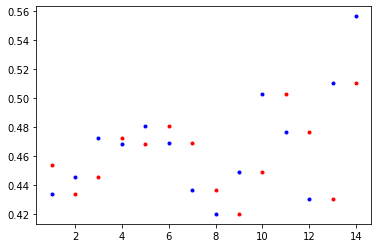

epoch 8, loss 0.035027652978897095


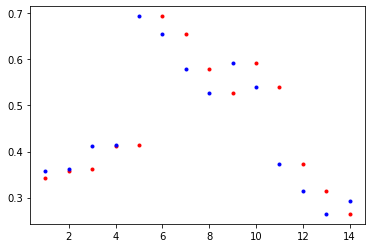

epoch 9, loss 0.03837272897362709


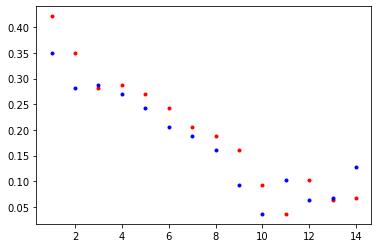

epoch 10, loss 0.011601120233535767


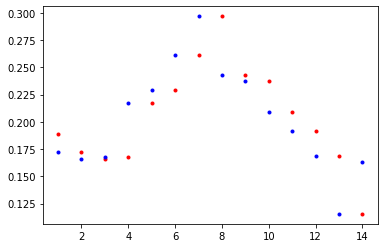

epoch 11, loss 0.009115283377468586


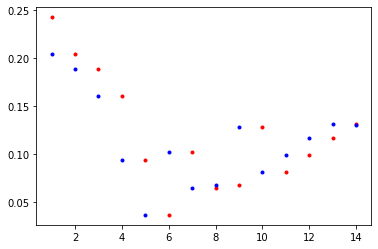

epoch 12, loss 0.0009742356487549841


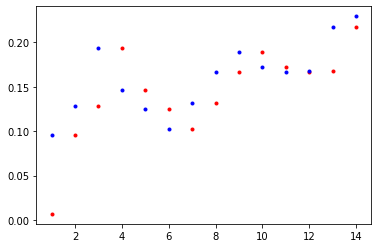

epoch 13, loss 0.0059524886310100555


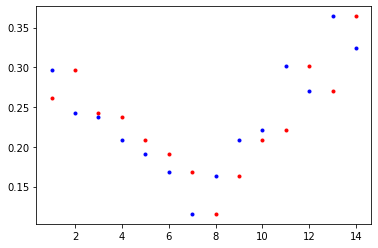

epoch 14, loss 0.04008365049958229


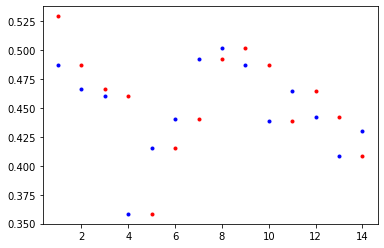

epoch 15, loss 0.004932491574436426


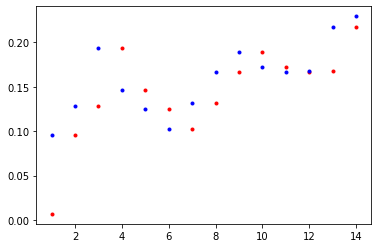

epoch 16, loss 0.007433662191033363


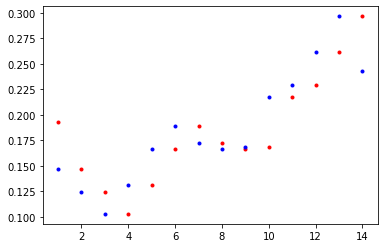

epoch 17, loss 0.0034053621347993612


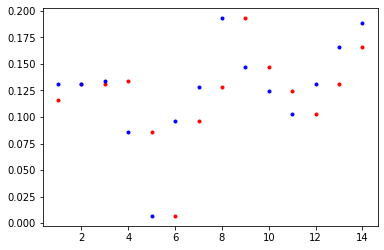

epoch 18, loss 0.01759282685816288


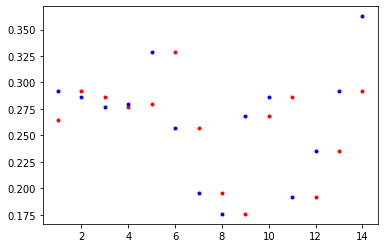

epoch 19, loss 0.007329164072871208


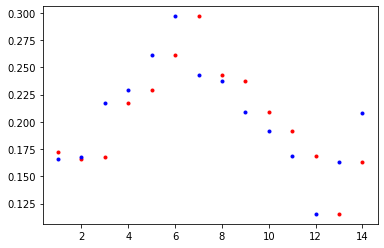

In [51]:
import random
trained_rnn = train(rnn,20)